# Looking for a representation of tempo in the data

In [2]:
# Cell 1: Import Libraries
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


## 2. Define Preprocessing Steps
1. Normalize
2. Create 3. Sek. Chunks to analyse, and use it for overlapping
3. Estimate the speed

In [60]:
def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    
    return y

def segment_audio(y, sr, segment_length=3.0, hop_length=1.0):
    """Segment audio into overlapping chunks without discarding any segments."""
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    
    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segment = y[start:end]
        
        # Add the segment without applying any RMS threshold
        segments.append(segment)
    
    return segments


## Load and process Audio Files
Audiofiles are loaded and processed in the following way: Resample to 16kHz, normalize to 0dB, and convert to mono. Segments are extracted from the audio files. The Segments are 3 seconds long and overlap by 1 second.

In [61]:
# Path to your dataset folder
dataset_path = '../dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio segments and tempo labels
audio_segments = []
tempo_labels = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    segments = segment_audio(y, sr=16000, segment_length=3.0, hop_length=1.0)
    for segment in segments:
        # Estimate tempo for each segment
        tempo = estimate_tempo(segment)
        audio_segments.append(segment)
        tempo_labels.append(tempo)

# Convert tempo_labels to a NumPy array
tempo_labels = np.array(tempo_labels)

# Identify valid indices where tempo is not NaN
valid_indices = ~np.isnan(tempo_labels)

# Filter the audio_segments and tempo_labels
audio_segments = [audio_segments[i] for i in range(len(audio_segments)) if valid_indices[i]]
tempo_labels = tempo_labels[valid_indices]


Loading and preprocessing audio files: 100%|██████████| 615/615 [00:34<00:00, 17.96it/s]


## Cell 4: Define Feature Extraction Function

In [62]:


def extract_features(y, sr=16000):
    """Extract various audio features."""
    # Tempogram features
    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
    tempogram_mean = np.mean(tempogram, axis=1)
    
    # MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    
    # Concatenate all features
    features = np.concatenate((tempogram_mean, mfcc_mean, chroma_mean, contrast_mean))
    return features




## Cell 5: Extract Features from All Segments

In [63]:


# Extract features for all segments
feature_vectors = []

for y in tqdm(audio_segments, desc='Extracting features'):
    features = extract_features(y)
    feature_vectors.append(features)

# Convert feature_vectors to a NumPy array
feature_vectors = np.array(feature_vectors)


Extracting features: 100%|██████████| 5638/5638 [01:40<00:00, 56.37it/s]


## Cell 6: Normalize Features

In [64]:


# Normalize features
feature_mean = np.mean(feature_vectors, axis=0)
feature_std = np.std(feature_vectors, axis=0)
feature_std[feature_std == 0] = 1e-6  # Avoid division by zero
feature_vectors_normalized = (feature_vectors - feature_mean) / feature_std

# Add a print statement to confirm variable creation
print("Feature vectors normalized shape:", feature_vectors_normalized.shape)


Feature vectors normalized shape: (5638, 416)


## Cell 7: Normalize Tempo Labels


In [65]:

# Compute the maximum tempo value
max_tempo = np.max(tempo_labels)

# Normalize tempo labels
tempo_labels_normalized = tempo_labels / max_tempo


## Cell 8: Create a Custom Dataset


In [66]:

from torch.utils.data import Dataset, DataLoader

class TempoDataset(Dataset):
    def __init__(self, feature_vectors, tempo_labels):
        self.feature_vectors = torch.tensor(feature_vectors).float()
        self.tempo_labels = torch.tensor(tempo_labels).float()

    def __len__(self):
        return len(self.feature_vectors)

    def __getitem__(self, idx):
        return self.feature_vectors[idx], self.tempo_labels[idx]


## Cell 9: Split Dataset


In [67]:

from sklearn.model_selection import train_test_split

# Use normalized features and labels
train_features, val_features, train_labels, val_labels = train_test_split(
    feature_vectors_normalized, tempo_labels_normalized, test_size=0.2, random_state=42)



## Cell 10: Create DataLoaders

Create DataLoaders

In [68]:
train_dataset = TempoDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TempoDataset(val_features, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Cell 11: Define the Regression Model
This network is designed to predict a tempo value (or a related feature) from the input data.


# Layers
1.  Fully Connected Layer (fc1): The first layer takes the input data (with input_size features) and maps it to hidden_size neurons.
2. ReLU Activation: Applies the Rectified Linear Unit (ReLU) activation, which introduces non-linearity, helping the network learn complex patterns.
3.  Dropout: Applies dropout regularization to prevent overfitting.
4. Second Fully Connected Layer (fc2): Reduces the number of neurons to half of the previous layer (hidden_size // 2), which helps in further feature extraction.
5. Output Layer (fc3): Maps the reduced hidden layer to a single output neuron, representing the predicted tempo.

The TempoRegressor is a feedforward neural network designed for regression tasks. It consists of three fully connected layers with ReLU activations and dropout for regularization. The sigmoid activation at the output ensures that the predicted value is in a normalized range. This architecture can effectively map input features (like audio characteristics) to a continuous value (e.g., tempo).


In [69]:
import torch.nn as nn

class TempoRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TempoRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        # New third hidden layer
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc4 = nn.Linear(hidden_size // 4, 1)
        self.sigmoid = nn.Sigmoid()  # Output between 0 and 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Forward pass through new third layer
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.squeeze()


# Cell 12: Initialize the Model

In [70]:
# Define input_size and hidden_size based on the new feature vector size
input_size = feature_vectors_normalized.shape[1]  # Number of features
hidden_size = 128  # Adjusted hidden size

# Initialize the updated model
model = TempoRegressor(input_size, hidden_size)


## Cell 13: Define Loss Function and Optimizer

1. nn.L1Loss(): Calculates the Mean Absolute Error (MAE), which is less sensitive to outliers than MSE and provides a clear measure of average error.
optim.
2. Adam: The Adam optimizer with a learning rate of 0.0001 is chosen for its adaptive learning capabilities and to ensure smooth, stable training. Reducing the learning rate helps the model make smaller, precise adjustments during weight updates, improving overall performance.

In [71]:


import torch.optim as optim

criterion = nn.L1Loss()  # Using Mean Absolute Error loss
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Reduced learning rate


## !!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




In [49]:
# Cell Before: Load the Best Model

import torch

# Ensure the model class TempoRegressor is defined
# and input_size, hidden_size are set

# Initialize the model
model = TempoRegressor(input_size, hidden_size)
model.to(device)

# Load the best model from checkpoints_05
checkpoint_dir = 'checkpoints_06'
best_model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

print("Best model loaded successfully for evaluation.")


Best model loaded successfully for evaluation.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_16769/1124066247.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

## Cell 14: Train the Model


Epoch 1/1000: 100%|██████████| 141/141 [00:00<00:00, 1242.98it/s]


Epoch [1/1000], Train Loss: 0.1367, Val Loss: 0.1324
Best model saved with validation loss: 0.1324


Epoch 2/1000: 100%|██████████| 141/141 [00:00<00:00, 1343.96it/s]


Epoch [2/1000], Train Loss: 0.1309, Val Loss: 0.1257
Best model saved with validation loss: 0.1257


Epoch 3/1000: 100%|██████████| 141/141 [00:00<00:00, 1229.07it/s]


Epoch [3/1000], Train Loss: 0.1238, Val Loss: 0.1188
Best model saved with validation loss: 0.1188


Epoch 4/1000: 100%|██████████| 141/141 [00:00<00:00, 1227.66it/s]


Epoch [4/1000], Train Loss: 0.1185, Val Loss: 0.1124
Best model saved with validation loss: 0.1124


Epoch 5/1000: 100%|██████████| 141/141 [00:00<00:00, 1137.45it/s]


Epoch [5/1000], Train Loss: 0.1143, Val Loss: 0.1070
Best model saved with validation loss: 0.1070


Epoch 6/1000: 100%|██████████| 141/141 [00:00<00:00, 1147.01it/s]


Epoch [6/1000], Train Loss: 0.1115, Val Loss: 0.1039
Best model saved with validation loss: 0.1039


Epoch 7/1000: 100%|██████████| 141/141 [00:00<00:00, 1357.90it/s]


Epoch [7/1000], Train Loss: 0.1095, Val Loss: 0.1015
Best model saved with validation loss: 0.1015


Epoch 8/1000: 100%|██████████| 141/141 [00:00<00:00, 1231.15it/s]


Epoch [8/1000], Train Loss: 0.1094, Val Loss: 0.1007
Best model saved with validation loss: 0.1007


Epoch 9/1000: 100%|██████████| 141/141 [00:00<00:00, 1231.06it/s]


Epoch [9/1000], Train Loss: 0.1080, Val Loss: 0.0995
Best model saved with validation loss: 0.0995


Epoch 10/1000: 100%|██████████| 141/141 [00:00<00:00, 1321.40it/s]


Epoch [10/1000], Train Loss: 0.1087, Val Loss: 0.0994
Best model saved with validation loss: 0.0994


Epoch 11/1000: 100%|██████████| 141/141 [00:00<00:00, 1276.38it/s]


Epoch [11/1000], Train Loss: 0.1070, Val Loss: 0.0991
Best model saved with validation loss: 0.0991


Epoch 12/1000: 100%|██████████| 141/141 [00:00<00:00, 937.06it/s]


Epoch [12/1000], Train Loss: 0.1064, Val Loss: 0.0983
Best model saved with validation loss: 0.0983


Epoch 13/1000: 100%|██████████| 141/141 [00:00<00:00, 1338.32it/s]


Epoch [13/1000], Train Loss: 0.1065, Val Loss: 0.0978
Best model saved with validation loss: 0.0978


Epoch 14/1000: 100%|██████████| 141/141 [00:00<00:00, 1257.56it/s]


Epoch [14/1000], Train Loss: 0.1053, Val Loss: 0.0980
No improvement in validation loss for 1 epoch(s).


Epoch 15/1000: 100%|██████████| 141/141 [00:00<00:00, 1360.61it/s]


Epoch [15/1000], Train Loss: 0.1051, Val Loss: 0.0977
Best model saved with validation loss: 0.0977


Epoch 16/1000: 100%|██████████| 141/141 [00:00<00:00, 1397.84it/s]


Epoch [16/1000], Train Loss: 0.1045, Val Loss: 0.0973
Best model saved with validation loss: 0.0973


Epoch 17/1000: 100%|██████████| 141/141 [00:00<00:00, 1172.26it/s]


Epoch [17/1000], Train Loss: 0.1026, Val Loss: 0.0967
Best model saved with validation loss: 0.0967


Epoch 18/1000: 100%|██████████| 141/141 [00:00<00:00, 1346.49it/s]


Epoch [18/1000], Train Loss: 0.1027, Val Loss: 0.0964
Best model saved with validation loss: 0.0964


Epoch 19/1000: 100%|██████████| 141/141 [00:00<00:00, 1308.77it/s]


Epoch [19/1000], Train Loss: 0.1030, Val Loss: 0.0966
No improvement in validation loss for 1 epoch(s).


Epoch 20/1000: 100%|██████████| 141/141 [00:00<00:00, 1224.18it/s]


Epoch [20/1000], Train Loss: 0.1023, Val Loss: 0.0958
Best model saved with validation loss: 0.0958


Epoch 21/1000: 100%|██████████| 141/141 [00:00<00:00, 1384.89it/s]


Epoch [21/1000], Train Loss: 0.1015, Val Loss: 0.0956
Best model saved with validation loss: 0.0956


Epoch 22/1000: 100%|██████████| 141/141 [00:00<00:00, 944.58it/s]


Epoch [22/1000], Train Loss: 0.1010, Val Loss: 0.0954
Best model saved with validation loss: 0.0954


Epoch 23/1000: 100%|██████████| 141/141 [00:00<00:00, 1343.20it/s]


Epoch [23/1000], Train Loss: 0.0999, Val Loss: 0.0946
Best model saved with validation loss: 0.0946


Epoch 24/1000: 100%|██████████| 141/141 [00:00<00:00, 1297.73it/s]


Epoch [24/1000], Train Loss: 0.1002, Val Loss: 0.0943
Best model saved with validation loss: 0.0943


Epoch 25/1000: 100%|██████████| 141/141 [00:00<00:00, 1323.55it/s]


Epoch [25/1000], Train Loss: 0.1000, Val Loss: 0.0941
Best model saved with validation loss: 0.0941


Epoch 26/1000: 100%|██████████| 141/141 [00:00<00:00, 1196.99it/s]


Epoch [26/1000], Train Loss: 0.0995, Val Loss: 0.0936
Best model saved with validation loss: 0.0936


Epoch 27/1000: 100%|██████████| 141/141 [00:00<00:00, 1384.46it/s]


Epoch [27/1000], Train Loss: 0.0994, Val Loss: 0.0932
Best model saved with validation loss: 0.0932


Epoch 28/1000: 100%|██████████| 141/141 [00:00<00:00, 1225.66it/s]


Epoch [28/1000], Train Loss: 0.0990, Val Loss: 0.0930
Best model saved with validation loss: 0.0930


Epoch 29/1000: 100%|██████████| 141/141 [00:00<00:00, 1330.96it/s]


Epoch [29/1000], Train Loss: 0.0979, Val Loss: 0.0930
Best model saved with validation loss: 0.0930


Epoch 30/1000: 100%|██████████| 141/141 [00:00<00:00, 1272.00it/s]


Epoch [30/1000], Train Loss: 0.0976, Val Loss: 0.0929
Best model saved with validation loss: 0.0929


Epoch 31/1000: 100%|██████████| 141/141 [00:00<00:00, 1240.16it/s]


Epoch [31/1000], Train Loss: 0.0974, Val Loss: 0.0930
No improvement in validation loss for 1 epoch(s).


Epoch 32/1000: 100%|██████████| 141/141 [00:00<00:00, 998.99it/s]


Epoch [32/1000], Train Loss: 0.0967, Val Loss: 0.0925
Best model saved with validation loss: 0.0925


Epoch 33/1000: 100%|██████████| 141/141 [00:00<00:00, 1404.06it/s]


Epoch [33/1000], Train Loss: 0.0975, Val Loss: 0.0921
Best model saved with validation loss: 0.0921


Epoch 34/1000: 100%|██████████| 141/141 [00:00<00:00, 1372.44it/s]


Epoch [34/1000], Train Loss: 0.0973, Val Loss: 0.0922
No improvement in validation loss for 1 epoch(s).


Epoch 35/1000: 100%|██████████| 141/141 [00:00<00:00, 1273.62it/s]


Epoch [35/1000], Train Loss: 0.0963, Val Loss: 0.0920
Best model saved with validation loss: 0.0920


Epoch 36/1000: 100%|██████████| 141/141 [00:00<00:00, 1360.91it/s]


Epoch [36/1000], Train Loss: 0.0964, Val Loss: 0.0916
Best model saved with validation loss: 0.0916


Epoch 37/1000: 100%|██████████| 141/141 [00:00<00:00, 1122.92it/s]


Epoch [37/1000], Train Loss: 0.0967, Val Loss: 0.0913
Best model saved with validation loss: 0.0913


Epoch 38/1000: 100%|██████████| 141/141 [00:00<00:00, 1228.34it/s]


Epoch [38/1000], Train Loss: 0.0969, Val Loss: 0.0911
Best model saved with validation loss: 0.0911


Epoch 39/1000: 100%|██████████| 141/141 [00:00<00:00, 1340.87it/s]


Epoch [39/1000], Train Loss: 0.0956, Val Loss: 0.0910
Best model saved with validation loss: 0.0910


Epoch 40/1000: 100%|██████████| 141/141 [00:00<00:00, 1231.85it/s]


Epoch [40/1000], Train Loss: 0.0959, Val Loss: 0.0910
No improvement in validation loss for 1 epoch(s).


Epoch 41/1000: 100%|██████████| 141/141 [00:00<00:00, 1230.57it/s]


Epoch [41/1000], Train Loss: 0.0958, Val Loss: 0.0909
Best model saved with validation loss: 0.0909


Epoch 42/1000: 100%|██████████| 141/141 [00:00<00:00, 1090.16it/s]


Epoch [42/1000], Train Loss: 0.0949, Val Loss: 0.0906
Best model saved with validation loss: 0.0906


Epoch 43/1000: 100%|██████████| 141/141 [00:00<00:00, 1299.91it/s]


Epoch [43/1000], Train Loss: 0.0958, Val Loss: 0.0904
Best model saved with validation loss: 0.0904


Epoch 44/1000: 100%|██████████| 141/141 [00:00<00:00, 1268.99it/s]


Epoch [44/1000], Train Loss: 0.0945, Val Loss: 0.0901
Best model saved with validation loss: 0.0901


Epoch 45/1000: 100%|██████████| 141/141 [00:00<00:00, 1349.65it/s]


Epoch [45/1000], Train Loss: 0.0941, Val Loss: 0.0897
Best model saved with validation loss: 0.0897


Epoch 46/1000: 100%|██████████| 141/141 [00:00<00:00, 1280.05it/s]


Epoch [46/1000], Train Loss: 0.0953, Val Loss: 0.0897
Best model saved with validation loss: 0.0897


Epoch 47/1000: 100%|██████████| 141/141 [00:00<00:00, 1417.52it/s]


Epoch [47/1000], Train Loss: 0.0947, Val Loss: 0.0897
Best model saved with validation loss: 0.0897


Epoch 48/1000: 100%|██████████| 141/141 [00:00<00:00, 1188.67it/s]


Epoch [48/1000], Train Loss: 0.0941, Val Loss: 0.0896
Best model saved with validation loss: 0.0896


Epoch 49/1000: 100%|██████████| 141/141 [00:00<00:00, 1399.83it/s]


Epoch [49/1000], Train Loss: 0.0943, Val Loss: 0.0895
Best model saved with validation loss: 0.0895


Epoch 50/1000: 100%|██████████| 141/141 [00:00<00:00, 1338.79it/s]


Epoch [50/1000], Train Loss: 0.0944, Val Loss: 0.0896
No improvement in validation loss for 1 epoch(s).


Epoch 51/1000: 100%|██████████| 141/141 [00:00<00:00, 1200.64it/s]


Epoch [51/1000], Train Loss: 0.0934, Val Loss: 0.0895
Best model saved with validation loss: 0.0895


Epoch 52/1000: 100%|██████████| 141/141 [00:00<00:00, 1111.79it/s]


Epoch [52/1000], Train Loss: 0.0936, Val Loss: 0.0893
Best model saved with validation loss: 0.0893


Epoch 53/1000: 100%|██████████| 141/141 [00:00<00:00, 1208.00it/s]


Epoch [53/1000], Train Loss: 0.0930, Val Loss: 0.0892
Best model saved with validation loss: 0.0892


Epoch 54/1000: 100%|██████████| 141/141 [00:00<00:00, 1359.66it/s]


Epoch [54/1000], Train Loss: 0.0945, Val Loss: 0.0892
No improvement in validation loss for 1 epoch(s).


Epoch 55/1000: 100%|██████████| 141/141 [00:00<00:00, 1352.18it/s]


Epoch [55/1000], Train Loss: 0.0932, Val Loss: 0.0892
Best model saved with validation loss: 0.0892


Epoch 56/1000: 100%|██████████| 141/141 [00:00<00:00, 1187.90it/s]


Epoch [56/1000], Train Loss: 0.0930, Val Loss: 0.0893
No improvement in validation loss for 1 epoch(s).


Epoch 57/1000: 100%|██████████| 141/141 [00:00<00:00, 1294.75it/s]


Epoch [57/1000], Train Loss: 0.0929, Val Loss: 0.0891
Best model saved with validation loss: 0.0891


Epoch 58/1000: 100%|██████████| 141/141 [00:00<00:00, 1142.16it/s]


Epoch [58/1000], Train Loss: 0.0919, Val Loss: 0.0889
Best model saved with validation loss: 0.0889


Epoch 59/1000: 100%|██████████| 141/141 [00:00<00:00, 1201.65it/s]


Epoch [59/1000], Train Loss: 0.0932, Val Loss: 0.0888
Best model saved with validation loss: 0.0888


Epoch 60/1000: 100%|██████████| 141/141 [00:00<00:00, 1382.57it/s]


Epoch [60/1000], Train Loss: 0.0926, Val Loss: 0.0886
Best model saved with validation loss: 0.0886


Epoch 61/1000: 100%|██████████| 141/141 [00:00<00:00, 1319.28it/s]


Epoch [61/1000], Train Loss: 0.0920, Val Loss: 0.0885
Best model saved with validation loss: 0.0885


Epoch 62/1000: 100%|██████████| 141/141 [00:00<00:00, 1008.53it/s]


Epoch [62/1000], Train Loss: 0.0920, Val Loss: 0.0884
Best model saved with validation loss: 0.0884


Epoch 63/1000: 100%|██████████| 141/141 [00:00<00:00, 1177.83it/s]


Epoch [63/1000], Train Loss: 0.0920, Val Loss: 0.0882
Best model saved with validation loss: 0.0882


Epoch 64/1000: 100%|██████████| 141/141 [00:00<00:00, 1396.25it/s]


Epoch [64/1000], Train Loss: 0.0919, Val Loss: 0.0883
No improvement in validation loss for 1 epoch(s).


Epoch 65/1000: 100%|██████████| 141/141 [00:00<00:00, 1350.35it/s]


Epoch [65/1000], Train Loss: 0.0919, Val Loss: 0.0879
Best model saved with validation loss: 0.0879


Epoch 66/1000: 100%|██████████| 141/141 [00:00<00:00, 1179.27it/s]


Epoch [66/1000], Train Loss: 0.0921, Val Loss: 0.0880
No improvement in validation loss for 1 epoch(s).


Epoch 67/1000: 100%|██████████| 141/141 [00:00<00:00, 1164.36it/s]


Epoch [67/1000], Train Loss: 0.0913, Val Loss: 0.0878
Best model saved with validation loss: 0.0878


Epoch 68/1000: 100%|██████████| 141/141 [00:00<00:00, 1327.12it/s]


Epoch [68/1000], Train Loss: 0.0923, Val Loss: 0.0877
Best model saved with validation loss: 0.0877


Epoch 69/1000: 100%|██████████| 141/141 [00:00<00:00, 1205.64it/s]


Epoch [69/1000], Train Loss: 0.0915, Val Loss: 0.0878
No improvement in validation loss for 1 epoch(s).


Epoch 70/1000: 100%|██████████| 141/141 [00:00<00:00, 1395.63it/s]


Epoch [70/1000], Train Loss: 0.0919, Val Loss: 0.0877
Best model saved with validation loss: 0.0877


Epoch 71/1000: 100%|██████████| 141/141 [00:00<00:00, 1358.12it/s]


Epoch [71/1000], Train Loss: 0.0918, Val Loss: 0.0874
Best model saved with validation loss: 0.0874


Epoch 72/1000: 100%|██████████| 141/141 [00:00<00:00, 1008.08it/s]


Epoch [72/1000], Train Loss: 0.0915, Val Loss: 0.0875
No improvement in validation loss for 1 epoch(s).


Epoch 73/1000: 100%|██████████| 141/141 [00:00<00:00, 1356.80it/s]


Epoch [73/1000], Train Loss: 0.0914, Val Loss: 0.0872
Best model saved with validation loss: 0.0872


Epoch 74/1000: 100%|██████████| 141/141 [00:00<00:00, 1331.78it/s]


Epoch [74/1000], Train Loss: 0.0908, Val Loss: 0.0872
Best model saved with validation loss: 0.0872


Epoch 75/1000: 100%|██████████| 141/141 [00:00<00:00, 1137.52it/s]


Epoch [75/1000], Train Loss: 0.0911, Val Loss: 0.0872
No improvement in validation loss for 1 epoch(s).


Epoch 76/1000: 100%|██████████| 141/141 [00:00<00:00, 1061.10it/s]


Epoch [76/1000], Train Loss: 0.0908, Val Loss: 0.0871
Best model saved with validation loss: 0.0871


Epoch 77/1000: 100%|██████████| 141/141 [00:00<00:00, 1354.08it/s]


Epoch [77/1000], Train Loss: 0.0903, Val Loss: 0.0868
Best model saved with validation loss: 0.0868


Epoch 78/1000: 100%|██████████| 141/141 [00:00<00:00, 1110.82it/s]


Epoch [78/1000], Train Loss: 0.0910, Val Loss: 0.0867
Best model saved with validation loss: 0.0867


Epoch 79/1000: 100%|██████████| 141/141 [00:00<00:00, 1385.82it/s]


Epoch [79/1000], Train Loss: 0.0903, Val Loss: 0.0865
Best model saved with validation loss: 0.0865


Epoch 80/1000: 100%|██████████| 141/141 [00:00<00:00, 1278.01it/s]


Epoch [80/1000], Train Loss: 0.0907, Val Loss: 0.0868
No improvement in validation loss for 1 epoch(s).


Epoch 81/1000: 100%|██████████| 141/141 [00:00<00:00, 1300.34it/s]


Epoch [81/1000], Train Loss: 0.0906, Val Loss: 0.0868
No improvement in validation loss for 2 epoch(s).


Epoch 82/1000: 100%|██████████| 141/141 [00:00<00:00, 1076.09it/s]


Epoch [82/1000], Train Loss: 0.0903, Val Loss: 0.0864
Best model saved with validation loss: 0.0864


Epoch 83/1000: 100%|██████████| 141/141 [00:00<00:00, 1350.21it/s]


Epoch [83/1000], Train Loss: 0.0911, Val Loss: 0.0860
Best model saved with validation loss: 0.0860


Epoch 84/1000: 100%|██████████| 141/141 [00:00<00:00, 1184.04it/s]


Epoch [84/1000], Train Loss: 0.0903, Val Loss: 0.0861
No improvement in validation loss for 1 epoch(s).


Epoch 85/1000: 100%|██████████| 141/141 [00:00<00:00, 1315.79it/s]


Epoch [85/1000], Train Loss: 0.0901, Val Loss: 0.0862
No improvement in validation loss for 2 epoch(s).


Epoch 86/1000: 100%|██████████| 141/141 [00:00<00:00, 1336.00it/s]


Epoch [86/1000], Train Loss: 0.0900, Val Loss: 0.0863
No improvement in validation loss for 3 epoch(s).


Epoch 87/1000: 100%|██████████| 141/141 [00:00<00:00, 1377.86it/s]


Epoch [87/1000], Train Loss: 0.0893, Val Loss: 0.0861
No improvement in validation loss for 4 epoch(s).


Epoch 88/1000: 100%|██████████| 141/141 [00:00<00:00, 1355.84it/s]


Epoch [88/1000], Train Loss: 0.0895, Val Loss: 0.0861
No improvement in validation loss for 5 epoch(s).


Epoch 89/1000: 100%|██████████| 141/141 [00:00<00:00, 1396.78it/s]


Epoch [89/1000], Train Loss: 0.0899, Val Loss: 0.0859
Best model saved with validation loss: 0.0859


Epoch 90/1000: 100%|██████████| 141/141 [00:00<00:00, 1403.04it/s]


Epoch [90/1000], Train Loss: 0.0894, Val Loss: 0.0858
Best model saved with validation loss: 0.0858


Epoch 91/1000: 100%|██████████| 141/141 [00:00<00:00, 1381.77it/s]


Epoch [91/1000], Train Loss: 0.0896, Val Loss: 0.0858
No improvement in validation loss for 1 epoch(s).


Epoch 92/1000: 100%|██████████| 141/141 [00:00<00:00, 1021.07it/s]


Epoch [92/1000], Train Loss: 0.0900, Val Loss: 0.0857
Best model saved with validation loss: 0.0857


Epoch 93/1000: 100%|██████████| 141/141 [00:00<00:00, 1364.24it/s]


Epoch [93/1000], Train Loss: 0.0891, Val Loss: 0.0856
Best model saved with validation loss: 0.0856


Epoch 94/1000: 100%|██████████| 141/141 [00:00<00:00, 1132.30it/s]


Epoch [94/1000], Train Loss: 0.0891, Val Loss: 0.0855
Best model saved with validation loss: 0.0855


Epoch 95/1000: 100%|██████████| 141/141 [00:00<00:00, 1331.42it/s]


Epoch [95/1000], Train Loss: 0.0887, Val Loss: 0.0856
No improvement in validation loss for 1 epoch(s).


Epoch 96/1000: 100%|██████████| 141/141 [00:00<00:00, 1358.48it/s]


Epoch [96/1000], Train Loss: 0.0892, Val Loss: 0.0855
Best model saved with validation loss: 0.0855


Epoch 97/1000: 100%|██████████| 141/141 [00:00<00:00, 1225.14it/s]


Epoch [97/1000], Train Loss: 0.0892, Val Loss: 0.0854
Best model saved with validation loss: 0.0854


Epoch 98/1000: 100%|██████████| 141/141 [00:00<00:00, 1219.90it/s]


Epoch [98/1000], Train Loss: 0.0891, Val Loss: 0.0854
Best model saved with validation loss: 0.0854


Epoch 99/1000: 100%|██████████| 141/141 [00:00<00:00, 1381.11it/s]


Epoch [99/1000], Train Loss: 0.0894, Val Loss: 0.0852
Best model saved with validation loss: 0.0852


Epoch 100/1000: 100%|██████████| 141/141 [00:00<00:00, 1204.65it/s]


Epoch [100/1000], Train Loss: 0.0892, Val Loss: 0.0851
Best model saved with validation loss: 0.0851


Epoch 101/1000: 100%|██████████| 141/141 [00:00<00:00, 1354.99it/s]


Epoch [101/1000], Train Loss: 0.0883, Val Loss: 0.0851
No improvement in validation loss for 1 epoch(s).


Epoch 102/1000: 100%|██████████| 141/141 [00:00<00:00, 904.51it/s]


Epoch [102/1000], Train Loss: 0.0882, Val Loss: 0.0852
No improvement in validation loss for 2 epoch(s).


Epoch 103/1000: 100%|██████████| 141/141 [00:00<00:00, 1381.35it/s]


Epoch [103/1000], Train Loss: 0.0888, Val Loss: 0.0849
Best model saved with validation loss: 0.0849


Epoch 104/1000: 100%|██████████| 141/141 [00:00<00:00, 1384.85it/s]


Epoch [104/1000], Train Loss: 0.0884, Val Loss: 0.0849
No improvement in validation loss for 1 epoch(s).


Epoch 105/1000: 100%|██████████| 141/141 [00:00<00:00, 1334.11it/s]


Epoch [105/1000], Train Loss: 0.0888, Val Loss: 0.0849
No improvement in validation loss for 2 epoch(s).


Epoch 106/1000: 100%|██████████| 141/141 [00:00<00:00, 1253.49it/s]


Epoch [106/1000], Train Loss: 0.0883, Val Loss: 0.0848
Best model saved with validation loss: 0.0848


Epoch 107/1000: 100%|██████████| 141/141 [00:00<00:00, 1395.22it/s]


Epoch [107/1000], Train Loss: 0.0892, Val Loss: 0.0846
Best model saved with validation loss: 0.0846


Epoch 108/1000: 100%|██████████| 141/141 [00:00<00:00, 1256.32it/s]


Epoch [108/1000], Train Loss: 0.0884, Val Loss: 0.0846
Best model saved with validation loss: 0.0846


Epoch 109/1000: 100%|██████████| 141/141 [00:00<00:00, 1322.14it/s]


Epoch [109/1000], Train Loss: 0.0881, Val Loss: 0.0848
No improvement in validation loss for 1 epoch(s).


Epoch 110/1000: 100%|██████████| 141/141 [00:00<00:00, 1184.29it/s]


Epoch [110/1000], Train Loss: 0.0877, Val Loss: 0.0846
No improvement in validation loss for 2 epoch(s).


Epoch 111/1000: 100%|██████████| 141/141 [00:00<00:00, 1355.46it/s]


Epoch [111/1000], Train Loss: 0.0892, Val Loss: 0.0844
Best model saved with validation loss: 0.0844


Epoch 112/1000: 100%|██████████| 141/141 [00:00<00:00, 1079.53it/s]


Epoch [112/1000], Train Loss: 0.0883, Val Loss: 0.0844
Best model saved with validation loss: 0.0844


Epoch 113/1000: 100%|██████████| 141/141 [00:00<00:00, 1284.87it/s]


Epoch [113/1000], Train Loss: 0.0878, Val Loss: 0.0844
Best model saved with validation loss: 0.0844


Epoch 114/1000: 100%|██████████| 141/141 [00:00<00:00, 1342.01it/s]


Epoch [114/1000], Train Loss: 0.0882, Val Loss: 0.0844
Best model saved with validation loss: 0.0844


Epoch 115/1000: 100%|██████████| 141/141 [00:00<00:00, 1162.13it/s]


Epoch [115/1000], Train Loss: 0.0869, Val Loss: 0.0845
No improvement in validation loss for 1 epoch(s).


Epoch 116/1000: 100%|██████████| 141/141 [00:00<00:00, 1350.08it/s]


Epoch [116/1000], Train Loss: 0.0878, Val Loss: 0.0842
Best model saved with validation loss: 0.0842


Epoch 117/1000: 100%|██████████| 141/141 [00:00<00:00, 1368.11it/s]


Epoch [117/1000], Train Loss: 0.0879, Val Loss: 0.0843
No improvement in validation loss for 1 epoch(s).


Epoch 118/1000: 100%|██████████| 141/141 [00:00<00:00, 1363.53it/s]


Epoch [118/1000], Train Loss: 0.0876, Val Loss: 0.0842
No improvement in validation loss for 2 epoch(s).


Epoch 119/1000: 100%|██████████| 141/141 [00:00<00:00, 1266.50it/s]


Epoch [119/1000], Train Loss: 0.0874, Val Loss: 0.0841
Best model saved with validation loss: 0.0841


Epoch 120/1000: 100%|██████████| 141/141 [00:00<00:00, 1359.32it/s]


Epoch [120/1000], Train Loss: 0.0871, Val Loss: 0.0840
Best model saved with validation loss: 0.0840


Epoch 121/1000: 100%|██████████| 141/141 [00:00<00:00, 1190.82it/s]


Epoch [121/1000], Train Loss: 0.0874, Val Loss: 0.0838
Best model saved with validation loss: 0.0838


Epoch 122/1000: 100%|██████████| 141/141 [00:00<00:00, 1045.91it/s]


Epoch [122/1000], Train Loss: 0.0872, Val Loss: 0.0841
No improvement in validation loss for 1 epoch(s).


Epoch 123/1000: 100%|██████████| 141/141 [00:00<00:00, 1231.42it/s]


Epoch [123/1000], Train Loss: 0.0870, Val Loss: 0.0839
No improvement in validation loss for 2 epoch(s).


Epoch 124/1000: 100%|██████████| 141/141 [00:00<00:00, 1367.01it/s]


Epoch [124/1000], Train Loss: 0.0873, Val Loss: 0.0839
No improvement in validation loss for 3 epoch(s).


Epoch 125/1000: 100%|██████████| 141/141 [00:00<00:00, 1266.10it/s]


Epoch [125/1000], Train Loss: 0.0868, Val Loss: 0.0837
Best model saved with validation loss: 0.0837


Epoch 126/1000: 100%|██████████| 141/141 [00:00<00:00, 1361.22it/s]


Epoch [126/1000], Train Loss: 0.0876, Val Loss: 0.0837
Best model saved with validation loss: 0.0837


Epoch 127/1000: 100%|██████████| 141/141 [00:00<00:00, 1282.52it/s]


Epoch [127/1000], Train Loss: 0.0876, Val Loss: 0.0835
Best model saved with validation loss: 0.0835


Epoch 128/1000: 100%|██████████| 141/141 [00:00<00:00, 1346.61it/s]


Epoch [128/1000], Train Loss: 0.0870, Val Loss: 0.0835
No improvement in validation loss for 1 epoch(s).


Epoch 129/1000: 100%|██████████| 141/141 [00:00<00:00, 1380.08it/s]


Epoch [129/1000], Train Loss: 0.0867, Val Loss: 0.0834
Best model saved with validation loss: 0.0834


Epoch 130/1000: 100%|██████████| 141/141 [00:00<00:00, 1189.51it/s]


Epoch [130/1000], Train Loss: 0.0866, Val Loss: 0.0833
Best model saved with validation loss: 0.0833


Epoch 131/1000: 100%|██████████| 141/141 [00:00<00:00, 1238.02it/s]


Epoch [131/1000], Train Loss: 0.0866, Val Loss: 0.0832
Best model saved with validation loss: 0.0832


Epoch 132/1000: 100%|██████████| 141/141 [00:00<00:00, 1103.32it/s]


Epoch [132/1000], Train Loss: 0.0874, Val Loss: 0.0831
Best model saved with validation loss: 0.0831


Epoch 133/1000: 100%|██████████| 141/141 [00:00<00:00, 1186.03it/s]


Epoch [133/1000], Train Loss: 0.0861, Val Loss: 0.0831
Best model saved with validation loss: 0.0831


Epoch 134/1000: 100%|██████████| 141/141 [00:00<00:00, 1335.19it/s]


Epoch [134/1000], Train Loss: 0.0866, Val Loss: 0.0831
No improvement in validation loss for 1 epoch(s).


Epoch 135/1000: 100%|██████████| 141/141 [00:00<00:00, 1277.40it/s]


Epoch [135/1000], Train Loss: 0.0860, Val Loss: 0.0831
Best model saved with validation loss: 0.0831


Epoch 136/1000: 100%|██████████| 141/141 [00:00<00:00, 1380.05it/s]


Epoch [136/1000], Train Loss: 0.0866, Val Loss: 0.0829
Best model saved with validation loss: 0.0829


Epoch 137/1000: 100%|██████████| 141/141 [00:00<00:00, 1189.37it/s]


Epoch [137/1000], Train Loss: 0.0866, Val Loss: 0.0832
No improvement in validation loss for 1 epoch(s).


Epoch 138/1000: 100%|██████████| 141/141 [00:00<00:00, 997.94it/s] 


Epoch [138/1000], Train Loss: 0.0864, Val Loss: 0.0829
No improvement in validation loss for 2 epoch(s).


Epoch 139/1000: 100%|██████████| 141/141 [00:00<00:00, 1277.75it/s]


Epoch [139/1000], Train Loss: 0.0855, Val Loss: 0.0828
Best model saved with validation loss: 0.0828


Epoch 140/1000: 100%|██████████| 141/141 [00:00<00:00, 1324.44it/s]


Epoch [140/1000], Train Loss: 0.0869, Val Loss: 0.0829
No improvement in validation loss for 1 epoch(s).


Epoch 141/1000: 100%|██████████| 141/141 [00:00<00:00, 1194.96it/s]


Epoch [141/1000], Train Loss: 0.0860, Val Loss: 0.0829
No improvement in validation loss for 2 epoch(s).


Epoch 142/1000: 100%|██████████| 141/141 [00:00<00:00, 1058.38it/s]


Epoch [142/1000], Train Loss: 0.0863, Val Loss: 0.0828
Best model saved with validation loss: 0.0828


Epoch 143/1000: 100%|██████████| 141/141 [00:00<00:00, 1357.37it/s]


Epoch [143/1000], Train Loss: 0.0853, Val Loss: 0.0829
No improvement in validation loss for 1 epoch(s).


Epoch 144/1000: 100%|██████████| 141/141 [00:00<00:00, 1135.55it/s]


Epoch [144/1000], Train Loss: 0.0855, Val Loss: 0.0828
No improvement in validation loss for 2 epoch(s).


Epoch 145/1000: 100%|██████████| 141/141 [00:00<00:00, 1309.51it/s]


Epoch [145/1000], Train Loss: 0.0854, Val Loss: 0.0827
Best model saved with validation loss: 0.0827


Epoch 146/1000: 100%|██████████| 141/141 [00:00<00:00, 1352.79it/s]


Epoch [146/1000], Train Loss: 0.0855, Val Loss: 0.0827
No improvement in validation loss for 1 epoch(s).


Epoch 147/1000: 100%|██████████| 141/141 [00:00<00:00, 1364.98it/s]


Epoch [147/1000], Train Loss: 0.0863, Val Loss: 0.0828
No improvement in validation loss for 2 epoch(s).


Epoch 148/1000: 100%|██████████| 141/141 [00:00<00:00, 1218.30it/s]


Epoch [148/1000], Train Loss: 0.0850, Val Loss: 0.0827
No improvement in validation loss for 3 epoch(s).


Epoch 149/1000: 100%|██████████| 141/141 [00:00<00:00, 1369.57it/s]


Epoch [149/1000], Train Loss: 0.0862, Val Loss: 0.0827
No improvement in validation loss for 4 epoch(s).


Epoch 150/1000: 100%|██████████| 141/141 [00:00<00:00, 1338.23it/s]


Epoch [150/1000], Train Loss: 0.0858, Val Loss: 0.0829
No improvement in validation loss for 5 epoch(s).


Epoch 151/1000: 100%|██████████| 141/141 [00:00<00:00, 1385.14it/s]


Epoch [151/1000], Train Loss: 0.0848, Val Loss: 0.0826
Best model saved with validation loss: 0.0826


Epoch 152/1000: 100%|██████████| 141/141 [00:00<00:00, 1043.69it/s]


Epoch [152/1000], Train Loss: 0.0857, Val Loss: 0.0826
Best model saved with validation loss: 0.0826


Epoch 153/1000: 100%|██████████| 141/141 [00:00<00:00, 1262.16it/s]


Epoch [153/1000], Train Loss: 0.0856, Val Loss: 0.0824
Best model saved with validation loss: 0.0824


Epoch 154/1000: 100%|██████████| 141/141 [00:00<00:00, 1363.74it/s]


Epoch [154/1000], Train Loss: 0.0852, Val Loss: 0.0822
Best model saved with validation loss: 0.0822


Epoch 155/1000: 100%|██████████| 141/141 [00:00<00:00, 1187.85it/s]


Epoch [155/1000], Train Loss: 0.0850, Val Loss: 0.0823
No improvement in validation loss for 1 epoch(s).


Epoch 156/1000: 100%|██████████| 141/141 [00:00<00:00, 1237.30it/s]


Epoch [156/1000], Train Loss: 0.0849, Val Loss: 0.0824
No improvement in validation loss for 2 epoch(s).


Epoch 157/1000: 100%|██████████| 141/141 [00:00<00:00, 1357.88it/s]


Epoch [157/1000], Train Loss: 0.0852, Val Loss: 0.0821
Best model saved with validation loss: 0.0821


Epoch 158/1000: 100%|██████████| 141/141 [00:00<00:00, 1395.08it/s]


Epoch [158/1000], Train Loss: 0.0858, Val Loss: 0.0821
Best model saved with validation loss: 0.0821


Epoch 159/1000: 100%|██████████| 141/141 [00:00<00:00, 1154.42it/s]


Epoch [159/1000], Train Loss: 0.0849, Val Loss: 0.0821
No improvement in validation loss for 1 epoch(s).


Epoch 160/1000: 100%|██████████| 141/141 [00:00<00:00, 1349.63it/s]


Epoch [160/1000], Train Loss: 0.0851, Val Loss: 0.0821
No improvement in validation loss for 2 epoch(s).


Epoch 161/1000: 100%|██████████| 141/141 [00:00<00:00, 1380.39it/s]


Epoch [161/1000], Train Loss: 0.0857, Val Loss: 0.0822
No improvement in validation loss for 3 epoch(s).


Epoch 162/1000: 100%|██████████| 141/141 [00:00<00:00, 1009.29it/s]


Epoch [162/1000], Train Loss: 0.0850, Val Loss: 0.0821
No improvement in validation loss for 4 epoch(s).


Epoch 163/1000: 100%|██████████| 141/141 [00:00<00:00, 1409.15it/s]


Epoch [163/1000], Train Loss: 0.0842, Val Loss: 0.0820
Best model saved with validation loss: 0.0820


Epoch 164/1000: 100%|██████████| 141/141 [00:00<00:00, 1378.97it/s]


Epoch [164/1000], Train Loss: 0.0846, Val Loss: 0.0822
No improvement in validation loss for 1 epoch(s).


Epoch 165/1000: 100%|██████████| 141/141 [00:00<00:00, 1191.17it/s]


Epoch [165/1000], Train Loss: 0.0850, Val Loss: 0.0821
No improvement in validation loss for 2 epoch(s).


Epoch 166/1000: 100%|██████████| 141/141 [00:00<00:00, 1354.49it/s]


Epoch [166/1000], Train Loss: 0.0850, Val Loss: 0.0820
No improvement in validation loss for 3 epoch(s).


Epoch 167/1000: 100%|██████████| 141/141 [00:00<00:00, 1310.14it/s]


Epoch [167/1000], Train Loss: 0.0854, Val Loss: 0.0820
No improvement in validation loss for 4 epoch(s).


Epoch 168/1000: 100%|██████████| 141/141 [00:00<00:00, 1315.95it/s]


Epoch [168/1000], Train Loss: 0.0843, Val Loss: 0.0818
Best model saved with validation loss: 0.0818


Epoch 169/1000: 100%|██████████| 141/141 [00:00<00:00, 1372.88it/s]


Epoch [169/1000], Train Loss: 0.0842, Val Loss: 0.0818
Best model saved with validation loss: 0.0818


Epoch 170/1000: 100%|██████████| 141/141 [00:00<00:00, 1137.43it/s]


Epoch [170/1000], Train Loss: 0.0852, Val Loss: 0.0818
No improvement in validation loss for 1 epoch(s).


Epoch 171/1000: 100%|██████████| 141/141 [00:00<00:00, 1364.84it/s]


Epoch [171/1000], Train Loss: 0.0851, Val Loss: 0.0818
No improvement in validation loss for 2 epoch(s).


Epoch 172/1000: 100%|██████████| 141/141 [00:00<00:00, 1016.72it/s]


Epoch [172/1000], Train Loss: 0.0844, Val Loss: 0.0817
Best model saved with validation loss: 0.0817


Epoch 173/1000: 100%|██████████| 141/141 [00:00<00:00, 1372.80it/s]


Epoch [173/1000], Train Loss: 0.0847, Val Loss: 0.0818
No improvement in validation loss for 1 epoch(s).


Epoch 174/1000: 100%|██████████| 141/141 [00:00<00:00, 1219.74it/s]


Epoch [174/1000], Train Loss: 0.0838, Val Loss: 0.0819
No improvement in validation loss for 2 epoch(s).


Epoch 175/1000: 100%|██████████| 141/141 [00:00<00:00, 1303.76it/s]


Epoch [175/1000], Train Loss: 0.0841, Val Loss: 0.0817
No improvement in validation loss for 3 epoch(s).


Epoch 176/1000: 100%|██████████| 141/141 [00:00<00:00, 1365.72it/s]


Epoch [176/1000], Train Loss: 0.0846, Val Loss: 0.0819
No improvement in validation loss for 4 epoch(s).


Epoch 177/1000: 100%|██████████| 141/141 [00:00<00:00, 1240.11it/s]


Epoch [177/1000], Train Loss: 0.0838, Val Loss: 0.0819
No improvement in validation loss for 5 epoch(s).


Epoch 178/1000: 100%|██████████| 141/141 [00:00<00:00, 1380.96it/s]


Epoch [178/1000], Train Loss: 0.0838, Val Loss: 0.0817
Best model saved with validation loss: 0.0817


Epoch 179/1000: 100%|██████████| 141/141 [00:00<00:00, 1375.09it/s]


Epoch [179/1000], Train Loss: 0.0840, Val Loss: 0.0816
Best model saved with validation loss: 0.0816


Epoch 180/1000: 100%|██████████| 141/141 [00:00<00:00, 1248.84it/s]


Epoch [180/1000], Train Loss: 0.0837, Val Loss: 0.0816
No improvement in validation loss for 1 epoch(s).


Epoch 181/1000: 100%|██████████| 141/141 [00:00<00:00, 1273.46it/s]


Epoch [181/1000], Train Loss: 0.0840, Val Loss: 0.0814
Best model saved with validation loss: 0.0814


Epoch 182/1000: 100%|██████████| 141/141 [00:00<00:00, 1324.13it/s]


Epoch [182/1000], Train Loss: 0.0843, Val Loss: 0.0814
No improvement in validation loss for 1 epoch(s).


Epoch 183/1000: 100%|██████████| 141/141 [00:00<00:00, 1325.69it/s]


Epoch [183/1000], Train Loss: 0.0833, Val Loss: 0.0813
Best model saved with validation loss: 0.0813


Epoch 184/1000: 100%|██████████| 141/141 [00:00<00:00, 1320.63it/s]


Epoch [184/1000], Train Loss: 0.0841, Val Loss: 0.0814
No improvement in validation loss for 1 epoch(s).


Epoch 185/1000: 100%|██████████| 141/141 [00:00<00:00, 1164.16it/s]


Epoch [185/1000], Train Loss: 0.0828, Val Loss: 0.0814
No improvement in validation loss for 2 epoch(s).


Epoch 186/1000: 100%|██████████| 141/141 [00:00<00:00, 1304.16it/s]


Epoch [186/1000], Train Loss: 0.0841, Val Loss: 0.0812
Best model saved with validation loss: 0.0812


Epoch 187/1000: 100%|██████████| 141/141 [00:00<00:00, 1327.88it/s]


Epoch [187/1000], Train Loss: 0.0840, Val Loss: 0.0813
No improvement in validation loss for 1 epoch(s).


Epoch 188/1000: 100%|██████████| 141/141 [00:00<00:00, 1324.29it/s]


Epoch [188/1000], Train Loss: 0.0837, Val Loss: 0.0810
Best model saved with validation loss: 0.0810


Epoch 189/1000: 100%|██████████| 141/141 [00:00<00:00, 1198.04it/s]


Epoch [189/1000], Train Loss: 0.0837, Val Loss: 0.0812
No improvement in validation loss for 1 epoch(s).


Epoch 190/1000: 100%|██████████| 141/141 [00:00<00:00, 1141.41it/s]


Epoch [190/1000], Train Loss: 0.0838, Val Loss: 0.0810
No improvement in validation loss for 2 epoch(s).


Epoch 191/1000: 100%|██████████| 141/141 [00:00<00:00, 1070.49it/s]


Epoch [191/1000], Train Loss: 0.0837, Val Loss: 0.0811
No improvement in validation loss for 3 epoch(s).


Epoch 192/1000: 100%|██████████| 141/141 [00:00<00:00, 1351.60it/s]


Epoch [192/1000], Train Loss: 0.0847, Val Loss: 0.0812
No improvement in validation loss for 4 epoch(s).


Epoch 193/1000: 100%|██████████| 141/141 [00:00<00:00, 1186.68it/s]


Epoch [193/1000], Train Loss: 0.0834, Val Loss: 0.0810
No improvement in validation loss for 5 epoch(s).


Epoch 194/1000: 100%|██████████| 141/141 [00:00<00:00, 1372.06it/s]


Epoch [194/1000], Train Loss: 0.0835, Val Loss: 0.0809
Best model saved with validation loss: 0.0809


Epoch 195/1000: 100%|██████████| 141/141 [00:00<00:00, 1358.25it/s]


Epoch [195/1000], Train Loss: 0.0833, Val Loss: 0.0810
No improvement in validation loss for 1 epoch(s).


Epoch 196/1000: 100%|██████████| 141/141 [00:00<00:00, 1237.95it/s]


Epoch [196/1000], Train Loss: 0.0829, Val Loss: 0.0810
No improvement in validation loss for 2 epoch(s).


Epoch 197/1000: 100%|██████████| 141/141 [00:00<00:00, 1332.89it/s]


Epoch [197/1000], Train Loss: 0.0838, Val Loss: 0.0808
Best model saved with validation loss: 0.0808


Epoch 198/1000: 100%|██████████| 141/141 [00:00<00:00, 1358.81it/s]


Epoch [198/1000], Train Loss: 0.0832, Val Loss: 0.0808
No improvement in validation loss for 1 epoch(s).


Epoch 199/1000: 100%|██████████| 141/141 [00:00<00:00, 1362.00it/s]


Epoch [199/1000], Train Loss: 0.0833, Val Loss: 0.0808
Best model saved with validation loss: 0.0808


Epoch 200/1000: 100%|██████████| 141/141 [00:00<00:00, 1219.47it/s]


Epoch [200/1000], Train Loss: 0.0835, Val Loss: 0.0809
No improvement in validation loss for 1 epoch(s).


Epoch 201/1000: 100%|██████████| 141/141 [00:00<00:00, 955.37it/s]


Epoch [201/1000], Train Loss: 0.0836, Val Loss: 0.0808
No improvement in validation loss for 2 epoch(s).


Epoch 202/1000: 100%|██████████| 141/141 [00:00<00:00, 1297.16it/s]


Epoch [202/1000], Train Loss: 0.0829, Val Loss: 0.0807
Best model saved with validation loss: 0.0807


Epoch 203/1000: 100%|██████████| 141/141 [00:00<00:00, 1343.79it/s]


Epoch [203/1000], Train Loss: 0.0826, Val Loss: 0.0806
Best model saved with validation loss: 0.0806


Epoch 204/1000: 100%|██████████| 141/141 [00:00<00:00, 1341.00it/s]


Epoch [204/1000], Train Loss: 0.0833, Val Loss: 0.0806
Best model saved with validation loss: 0.0806


Epoch 205/1000: 100%|██████████| 141/141 [00:00<00:00, 1246.65it/s]


Epoch [205/1000], Train Loss: 0.0828, Val Loss: 0.0806
Best model saved with validation loss: 0.0806


Epoch 206/1000: 100%|██████████| 141/141 [00:00<00:00, 1168.48it/s]


Epoch [206/1000], Train Loss: 0.0825, Val Loss: 0.0807
No improvement in validation loss for 1 epoch(s).


Epoch 207/1000: 100%|██████████| 141/141 [00:00<00:00, 1240.00it/s]


Epoch [207/1000], Train Loss: 0.0820, Val Loss: 0.0807
No improvement in validation loss for 2 epoch(s).


Epoch 208/1000: 100%|██████████| 141/141 [00:00<00:00, 1381.46it/s]


Epoch [208/1000], Train Loss: 0.0821, Val Loss: 0.0806
No improvement in validation loss for 3 epoch(s).


Epoch 209/1000: 100%|██████████| 141/141 [00:00<00:00, 1342.68it/s]


Epoch [209/1000], Train Loss: 0.0827, Val Loss: 0.0807
No improvement in validation loss for 4 epoch(s).


Epoch 210/1000: 100%|██████████| 141/141 [00:00<00:00, 1066.67it/s]


Epoch [210/1000], Train Loss: 0.0826, Val Loss: 0.0805
Best model saved with validation loss: 0.0805


Epoch 211/1000: 100%|██████████| 141/141 [00:00<00:00, 1376.66it/s]


Epoch [211/1000], Train Loss: 0.0823, Val Loss: 0.0802
Best model saved with validation loss: 0.0802


Epoch 212/1000: 100%|██████████| 141/141 [00:00<00:00, 1228.48it/s]


Epoch [212/1000], Train Loss: 0.0833, Val Loss: 0.0804
No improvement in validation loss for 1 epoch(s).


Epoch 213/1000: 100%|██████████| 141/141 [00:00<00:00, 1342.56it/s]


Epoch [213/1000], Train Loss: 0.0830, Val Loss: 0.0805
No improvement in validation loss for 2 epoch(s).


Epoch 214/1000: 100%|██████████| 141/141 [00:00<00:00, 1371.54it/s]


Epoch [214/1000], Train Loss: 0.0825, Val Loss: 0.0804
No improvement in validation loss for 3 epoch(s).


Epoch 215/1000: 100%|██████████| 141/141 [00:00<00:00, 1325.04it/s]


Epoch [215/1000], Train Loss: 0.0820, Val Loss: 0.0804
No improvement in validation loss for 4 epoch(s).


Epoch 216/1000: 100%|██████████| 141/141 [00:00<00:00, 1380.67it/s]


Epoch [216/1000], Train Loss: 0.0825, Val Loss: 0.0804
No improvement in validation loss for 5 epoch(s).


Epoch 217/1000: 100%|██████████| 141/141 [00:00<00:00, 1357.78it/s]


Epoch [217/1000], Train Loss: 0.0825, Val Loss: 0.0803
No improvement in validation loss for 6 epoch(s).


Epoch 218/1000: 100%|██████████| 141/141 [00:00<00:00, 1358.46it/s]


Epoch [218/1000], Train Loss: 0.0826, Val Loss: 0.0803
No improvement in validation loss for 7 epoch(s).


Epoch 219/1000: 100%|██████████| 141/141 [00:00<00:00, 1364.96it/s]


Epoch [219/1000], Train Loss: 0.0818, Val Loss: 0.0802
Best model saved with validation loss: 0.0802


Epoch 220/1000: 100%|██████████| 141/141 [00:00<00:00, 1014.98it/s]


Epoch [220/1000], Train Loss: 0.0823, Val Loss: 0.0803
No improvement in validation loss for 1 epoch(s).


Epoch 221/1000: 100%|██████████| 141/141 [00:00<00:00, 1222.75it/s]


Epoch [221/1000], Train Loss: 0.0828, Val Loss: 0.0805
No improvement in validation loss for 2 epoch(s).


Epoch 222/1000: 100%|██████████| 141/141 [00:00<00:00, 1320.29it/s]


Epoch [222/1000], Train Loss: 0.0826, Val Loss: 0.0805
No improvement in validation loss for 3 epoch(s).


Epoch 223/1000: 100%|██████████| 141/141 [00:00<00:00, 1319.96it/s]


Epoch [223/1000], Train Loss: 0.0822, Val Loss: 0.0804
No improvement in validation loss for 4 epoch(s).


Epoch 224/1000: 100%|██████████| 141/141 [00:00<00:00, 1355.21it/s]


Epoch [224/1000], Train Loss: 0.0829, Val Loss: 0.0803
No improvement in validation loss for 5 epoch(s).


Epoch 225/1000: 100%|██████████| 141/141 [00:00<00:00, 1329.16it/s]


Epoch [225/1000], Train Loss: 0.0820, Val Loss: 0.0802
No improvement in validation loss for 6 epoch(s).


Epoch 226/1000: 100%|██████████| 141/141 [00:00<00:00, 1365.41it/s]


Epoch [226/1000], Train Loss: 0.0819, Val Loss: 0.0802
Best model saved with validation loss: 0.0802


Epoch 227/1000: 100%|██████████| 141/141 [00:00<00:00, 1355.21it/s]


Epoch [227/1000], Train Loss: 0.0826, Val Loss: 0.0802
No improvement in validation loss for 1 epoch(s).


Epoch 228/1000: 100%|██████████| 141/141 [00:00<00:00, 1193.15it/s]


Epoch [228/1000], Train Loss: 0.0821, Val Loss: 0.0801
Best model saved with validation loss: 0.0801


Epoch 229/1000: 100%|██████████| 141/141 [00:00<00:00, 1032.54it/s]


Epoch [229/1000], Train Loss: 0.0819, Val Loss: 0.0801
Best model saved with validation loss: 0.0801


Epoch 230/1000: 100%|██████████| 141/141 [00:00<00:00, 1185.60it/s]


Epoch [230/1000], Train Loss: 0.0821, Val Loss: 0.0800
Best model saved with validation loss: 0.0800


Epoch 231/1000: 100%|██████████| 141/141 [00:00<00:00, 1324.98it/s]


Epoch [231/1000], Train Loss: 0.0826, Val Loss: 0.0800
Best model saved with validation loss: 0.0800


Epoch 232/1000: 100%|██████████| 141/141 [00:00<00:00, 1189.34it/s]


Epoch [232/1000], Train Loss: 0.0826, Val Loss: 0.0799
Best model saved with validation loss: 0.0799


Epoch 233/1000: 100%|██████████| 141/141 [00:00<00:00, 1269.86it/s]


Epoch [233/1000], Train Loss: 0.0812, Val Loss: 0.0798
Best model saved with validation loss: 0.0798


Epoch 234/1000: 100%|██████████| 141/141 [00:00<00:00, 1294.20it/s]


Epoch [234/1000], Train Loss: 0.0815, Val Loss: 0.0798
Best model saved with validation loss: 0.0798


Epoch 235/1000: 100%|██████████| 141/141 [00:00<00:00, 1125.33it/s]


Epoch [235/1000], Train Loss: 0.0818, Val Loss: 0.0798
No improvement in validation loss for 1 epoch(s).


Epoch 236/1000: 100%|██████████| 141/141 [00:00<00:00, 1318.99it/s]


Epoch [236/1000], Train Loss: 0.0819, Val Loss: 0.0800
No improvement in validation loss for 2 epoch(s).


Epoch 237/1000: 100%|██████████| 141/141 [00:00<00:00, 1311.89it/s]


Epoch [237/1000], Train Loss: 0.0824, Val Loss: 0.0797
Best model saved with validation loss: 0.0797


Epoch 238/1000: 100%|██████████| 141/141 [00:00<00:00, 1068.77it/s]


Epoch [238/1000], Train Loss: 0.0825, Val Loss: 0.0797
Best model saved with validation loss: 0.0797


Epoch 239/1000: 100%|██████████| 141/141 [00:00<00:00, 1328.75it/s]


Epoch [239/1000], Train Loss: 0.0818, Val Loss: 0.0798
No improvement in validation loss for 1 epoch(s).


Epoch 240/1000: 100%|██████████| 141/141 [00:00<00:00, 1283.76it/s]


Epoch [240/1000], Train Loss: 0.0820, Val Loss: 0.0797
Best model saved with validation loss: 0.0797


Epoch 241/1000: 100%|██████████| 141/141 [00:00<00:00, 1370.88it/s]


Epoch [241/1000], Train Loss: 0.0818, Val Loss: 0.0797
No improvement in validation loss for 1 epoch(s).


Epoch 242/1000: 100%|██████████| 141/141 [00:00<00:00, 1331.62it/s]


Epoch [242/1000], Train Loss: 0.0816, Val Loss: 0.0796
Best model saved with validation loss: 0.0796


Epoch 243/1000: 100%|██████████| 141/141 [00:00<00:00, 1235.67it/s]


Epoch [243/1000], Train Loss: 0.0820, Val Loss: 0.0798
No improvement in validation loss for 1 epoch(s).


Epoch 244/1000: 100%|██████████| 141/141 [00:00<00:00, 1300.38it/s]


Epoch [244/1000], Train Loss: 0.0815, Val Loss: 0.0798
No improvement in validation loss for 2 epoch(s).


Epoch 245/1000: 100%|██████████| 141/141 [00:00<00:00, 1218.65it/s]


Epoch [245/1000], Train Loss: 0.0817, Val Loss: 0.0798
No improvement in validation loss for 3 epoch(s).


Epoch 246/1000: 100%|██████████| 141/141 [00:00<00:00, 1379.30it/s]


Epoch [246/1000], Train Loss: 0.0822, Val Loss: 0.0795
Best model saved with validation loss: 0.0795


Epoch 247/1000: 100%|██████████| 141/141 [00:00<00:00, 1034.36it/s]


Epoch [247/1000], Train Loss: 0.0813, Val Loss: 0.0795
Best model saved with validation loss: 0.0795


Epoch 248/1000: 100%|██████████| 141/141 [00:00<00:00, 1346.99it/s]


Epoch [248/1000], Train Loss: 0.0812, Val Loss: 0.0796
No improvement in validation loss for 1 epoch(s).


Epoch 249/1000: 100%|██████████| 141/141 [00:00<00:00, 1230.83it/s]


Epoch [249/1000], Train Loss: 0.0815, Val Loss: 0.0798
No improvement in validation loss for 2 epoch(s).


Epoch 250/1000: 100%|██████████| 141/141 [00:00<00:00, 1356.62it/s]


Epoch [250/1000], Train Loss: 0.0822, Val Loss: 0.0798
No improvement in validation loss for 3 epoch(s).


Epoch 251/1000: 100%|██████████| 141/141 [00:00<00:00, 1282.19it/s]


Epoch [251/1000], Train Loss: 0.0811, Val Loss: 0.0796
No improvement in validation loss for 4 epoch(s).


Epoch 252/1000: 100%|██████████| 141/141 [00:00<00:00, 1408.96it/s]


Epoch [252/1000], Train Loss: 0.0818, Val Loss: 0.0796
No improvement in validation loss for 5 epoch(s).


Epoch 253/1000: 100%|██████████| 141/141 [00:00<00:00, 1448.31it/s]


Epoch [253/1000], Train Loss: 0.0814, Val Loss: 0.0796
No improvement in validation loss for 6 epoch(s).


Epoch 254/1000: 100%|██████████| 141/141 [00:00<00:00, 1449.89it/s]


Epoch [254/1000], Train Loss: 0.0814, Val Loss: 0.0796
No improvement in validation loss for 7 epoch(s).


Epoch 255/1000: 100%|██████████| 141/141 [00:00<00:00, 1423.87it/s]


Epoch [255/1000], Train Loss: 0.0812, Val Loss: 0.0795
Best model saved with validation loss: 0.0795


Epoch 256/1000: 100%|██████████| 141/141 [00:00<00:00, 1427.01it/s]


Epoch [256/1000], Train Loss: 0.0813, Val Loss: 0.0794
Best model saved with validation loss: 0.0794


Epoch 257/1000: 100%|██████████| 141/141 [00:00<00:00, 1446.87it/s]


Epoch [257/1000], Train Loss: 0.0809, Val Loss: 0.0795
No improvement in validation loss for 1 epoch(s).


Epoch 258/1000: 100%|██████████| 141/141 [00:00<00:00, 1226.10it/s]


Epoch [258/1000], Train Loss: 0.0808, Val Loss: 0.0796
No improvement in validation loss for 2 epoch(s).


Epoch 259/1000: 100%|██████████| 141/141 [00:00<00:00, 1443.30it/s]


Epoch [259/1000], Train Loss: 0.0820, Val Loss: 0.0795
No improvement in validation loss for 3 epoch(s).


Epoch 260/1000: 100%|██████████| 141/141 [00:00<00:00, 1111.23it/s]


Epoch [260/1000], Train Loss: 0.0813, Val Loss: 0.0794
Best model saved with validation loss: 0.0794


Epoch 261/1000: 100%|██████████| 141/141 [00:00<00:00, 1448.05it/s]


Epoch [261/1000], Train Loss: 0.0811, Val Loss: 0.0794
No improvement in validation loss for 1 epoch(s).


Epoch 262/1000: 100%|██████████| 141/141 [00:00<00:00, 1287.89it/s]


Epoch [262/1000], Train Loss: 0.0809, Val Loss: 0.0794
No improvement in validation loss for 2 epoch(s).


Epoch 263/1000: 100%|██████████| 141/141 [00:00<00:00, 1384.02it/s]


Epoch [263/1000], Train Loss: 0.0809, Val Loss: 0.0794
No improvement in validation loss for 3 epoch(s).


Epoch 264/1000: 100%|██████████| 141/141 [00:00<00:00, 1424.49it/s]


Epoch [264/1000], Train Loss: 0.0814, Val Loss: 0.0794
No improvement in validation loss for 4 epoch(s).


Epoch 265/1000: 100%|██████████| 141/141 [00:00<00:00, 1438.17it/s]


Epoch [265/1000], Train Loss: 0.0810, Val Loss: 0.0794
No improvement in validation loss for 5 epoch(s).


Epoch 266/1000: 100%|██████████| 141/141 [00:00<00:00, 1411.61it/s]


Epoch [266/1000], Train Loss: 0.0805, Val Loss: 0.0794
No improvement in validation loss for 6 epoch(s).


Epoch 267/1000: 100%|██████████| 141/141 [00:00<00:00, 1452.98it/s]


Epoch [267/1000], Train Loss: 0.0805, Val Loss: 0.0793
Best model saved with validation loss: 0.0793


Epoch 268/1000: 100%|██████████| 141/141 [00:00<00:00, 1439.69it/s]


Epoch [268/1000], Train Loss: 0.0810, Val Loss: 0.0794
No improvement in validation loss for 1 epoch(s).


Epoch 269/1000: 100%|██████████| 141/141 [00:00<00:00, 1430.71it/s]


Epoch [269/1000], Train Loss: 0.0811, Val Loss: 0.0795
No improvement in validation loss for 2 epoch(s).


Epoch 270/1000: 100%|██████████| 141/141 [00:00<00:00, 1274.20it/s]


Epoch [270/1000], Train Loss: 0.0811, Val Loss: 0.0793
No improvement in validation loss for 3 epoch(s).


Epoch 271/1000: 100%|██████████| 141/141 [00:00<00:00, 1398.90it/s]


Epoch [271/1000], Train Loss: 0.0806, Val Loss: 0.0793
No improvement in validation loss for 4 epoch(s).


Epoch 272/1000: 100%|██████████| 141/141 [00:00<00:00, 1422.62it/s]


Epoch [272/1000], Train Loss: 0.0805, Val Loss: 0.0796
No improvement in validation loss for 5 epoch(s).


Epoch 273/1000: 100%|██████████| 141/141 [00:00<00:00, 1451.15it/s]


Epoch [273/1000], Train Loss: 0.0814, Val Loss: 0.0795
No improvement in validation loss for 6 epoch(s).


Epoch 274/1000: 100%|██████████| 141/141 [00:00<00:00, 1428.45it/s]


Epoch [274/1000], Train Loss: 0.0808, Val Loss: 0.0795
No improvement in validation loss for 7 epoch(s).


Epoch 275/1000: 100%|██████████| 141/141 [00:00<00:00, 1434.21it/s]


Epoch [275/1000], Train Loss: 0.0810, Val Loss: 0.0793
No improvement in validation loss for 8 epoch(s).


Epoch 276/1000: 100%|██████████| 141/141 [00:00<00:00, 1443.35it/s]


Epoch [276/1000], Train Loss: 0.0803, Val Loss: 0.0795
No improvement in validation loss for 9 epoch(s).


Epoch 277/1000: 100%|██████████| 141/141 [00:00<00:00, 1255.15it/s]

Epoch [277/1000], Train Loss: 0.0812, Val Loss: 0.0794
No improvement in validation loss for 10 epoch(s).
Early stopping triggered.


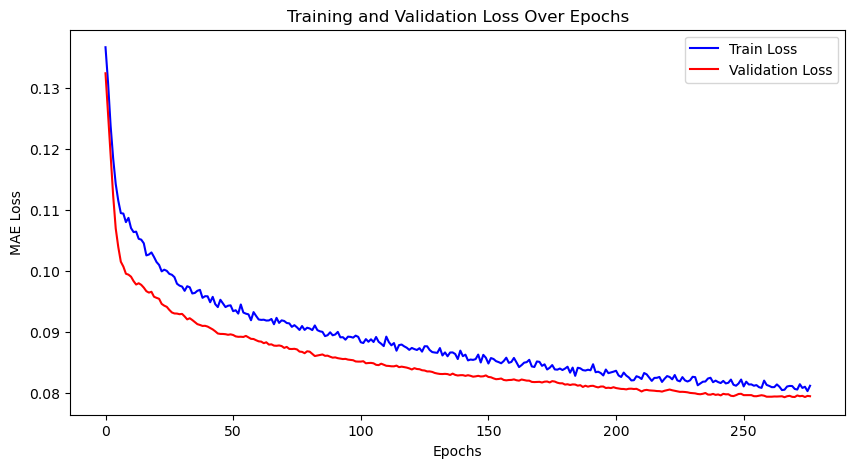

In [72]:

# import torch
# import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Ensure 'checkpoint_dir' is defined
checkpoint_dir = 'checkpoints_06'  # Update as needed
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Set the number of epochs and early stopping parameters
num_epochs = 1000
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_data, batch_labels in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_data, val_labels in val_dataloader:
            val_data = val_data.to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_data)
            loss = criterion(outputs, val_labels)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early Stopping and Checkpoint Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save only the model's state_dict
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_tempo_model.pth'))
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data

Mean Absolute Error in Tempo Estimation: 24.66 BPM


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_89855/3186413704.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

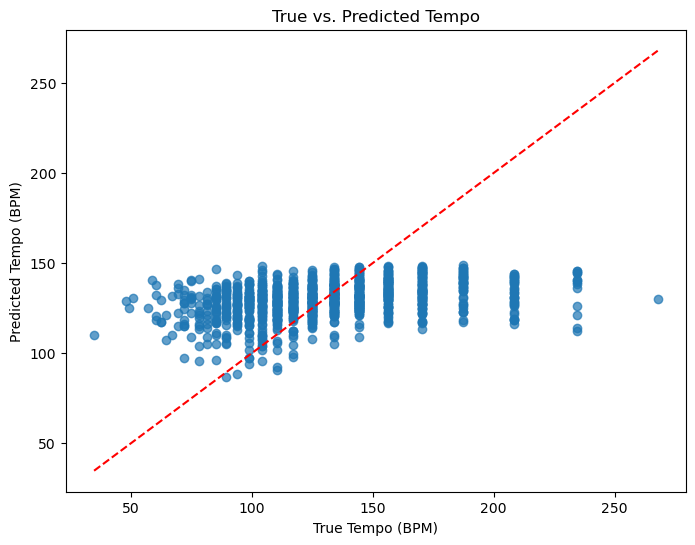

In [73]:
from sklearn.metrics import mean_absolute_error

# Load the best model from checkpoints_05
checkpoint_dir = 'checkpoints_06'  # Specify the directory where your model is saved
model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')  # Adjust the filename if needed

# Load the model's state_dict
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

true_tempos = []
predicted_tempos = []

with torch.no_grad():
    for val_data, val_labels in val_dataloader:
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)

        outputs = model(val_data)

        # Collect true and predicted tempos
        true_tempos.extend(val_labels.cpu().numpy())
        predicted_tempos.extend(outputs.cpu().numpy())

# Rescale predictions and true labels back to original tempo range
true_tempos_rescaled = [t * max_tempo for t in true_tempos]
predicted_tempos_rescaled = [p * max_tempo for p in predicted_tempos]

# Compute Mean Absolute Error
mae = mean_absolute_error(true_tempos_rescaled, predicted_tempos_rescaled)
print(f"Mean Absolute Error in Tempo Estimation: {mae:.2f} BPM")

# Plot true vs. predicted tempos
plt.figure(figsize=(8, 6))
plt.scatter(true_tempos_rescaled, predicted_tempos_rescaled, alpha=0.7)
plt.plot([min(true_tempos_rescaled), max(true_tempos_rescaled)],
         [min(true_tempos_rescaled), max(true_tempos_rescaled)], 'r--')
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Predicted Tempo (BPM)')
plt.title('True vs. Predicted Tempo')
plt.show()


## Transform to ONNX

In [74]:
# Assuming the model has already been instantiated and is available as `model`
# Define the directory and file paths
checkpoint_dir = 'checkpoints_06'  # Directory to save/load the ONNX model
os.makedirs(checkpoint_dir, exist_ok=True)

# Load your trained model from the specified checkpoint directory
model_path = os.path.join(checkpoint_dir, 'best_tempo_model.pth')
onnx_model_path = os.path.join(checkpoint_dir, 'tempo_model.onnx')

# Load the state_dict into the existing model instance
model.load_state_dict(torch.load(model_path))
model.eval()

# Dummy input for the model (size should match the input size of your model)
dummy_input = torch.randn(1, model.fc1.in_features)  # `model.fc1.in_features` gets the input size

# Export the model to ONNX and save it in the specified directory
torch.onnx.export(model, dummy_input, onnx_model_path, opset_version=11)

print(f"ONNX model saved to {onnx_model_path}")


ONNX model saved to checkpoints_06/tempo_model.onnx


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_89855/2930334969.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)